Note: must turn off radar in settings before recording

In [3]:
#imports + file upload
from google.colab import files
import numpy as np
from skimage.color import rgb2gray
import os
import pandas as pd
from collections import Counter
from random import shuffle
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt

#uploaded = files.upload()

In [4]:
#data processing

#next steps: use GAN to debias dataset (MIT 6.S191 lec 4, lab 2)
s_turn = []
m_turn = []
adj_turn = []
no_turn = []
starting_value = 0
continue_loop = True
while continue_loop:
  data_file_name = 'processed-training_data-{}.npy'.format(starting_value)
  if os.path.isfile(data_file_name):
    processed_data = np.load(data_file_name,allow_pickle=True)    
    for entry in processed_data:
      y = entry[1]
      y_ls = y[2]
      x = rgb2gray(entry[0])
      #flipping images
      y_flipped = [y[0],y[1],1-y_ls]
      x_flipped = cv2.flip(x, 1)

      if (y_ls > 0.875 or y_ls < 0.125):
        #very sharp turn, but it doesn't warrant its own array
        s_turn.append([x,y])
        s_turn.append([x_flipped,y_flipped])
      elif (y_ls > 0.8 or y_ls < 0.2):
        #sharp turn
        s_turn.append([x_flipped,y_flipped])
        s_turn.append([x,y])
      elif (y_ls > 0.7 or y_ls < 0.3):
        #medium turn
        m_turn.append([x,y])
        m_turn.append([x_flipped,y_flipped])

      elif (y_ls > 0.65 or y_ls < 0.35):
        #light turn, doesn't warrant its own array
        m_turn.append([x,y])
        m_turn.append([x_flipped,y_flipped])

      elif (y_ls > 0.575 or y_ls < 0.425):
        #adjustments
        adj_turn.append([x,y])
        adj_turn.append([x_flipped,y_flipped])
      else:
        #no turn
        no_turn.append([x,y])
        no_turn.append([x_flipped,y_flipped])
  else:
    continue_loop = False

shuffle(no_turn)
#without shuffling, array adjustment in next step would mean that the training set is full of mirror repeats 
#we would prefer to have [img12_mirrored,img1] rather than [img1_mirrored, img1]
#shuffling allows for this

balanced_data = s_turn + m_turn + adj_turn + no_turn[0:len(adj_turn)]

shuffle(balanced_data)

print("done! have {} test cases".format(len(balanced_data)))
#we want agent to make small adjustments, so adj_turn isn't being adjusted
#we don't want agent to just go straight, so less of no_turn is being added

done! have 0 test cases


In [5]:
#saving chunk of training data as testing data
PERCENT_TEST = 20

test_index_start = int(PERCENT_TEST*len(balanced_data)/100)
train_data = balanced_data[:test_index_start]
test_data = balanced_data[test_index_start:]

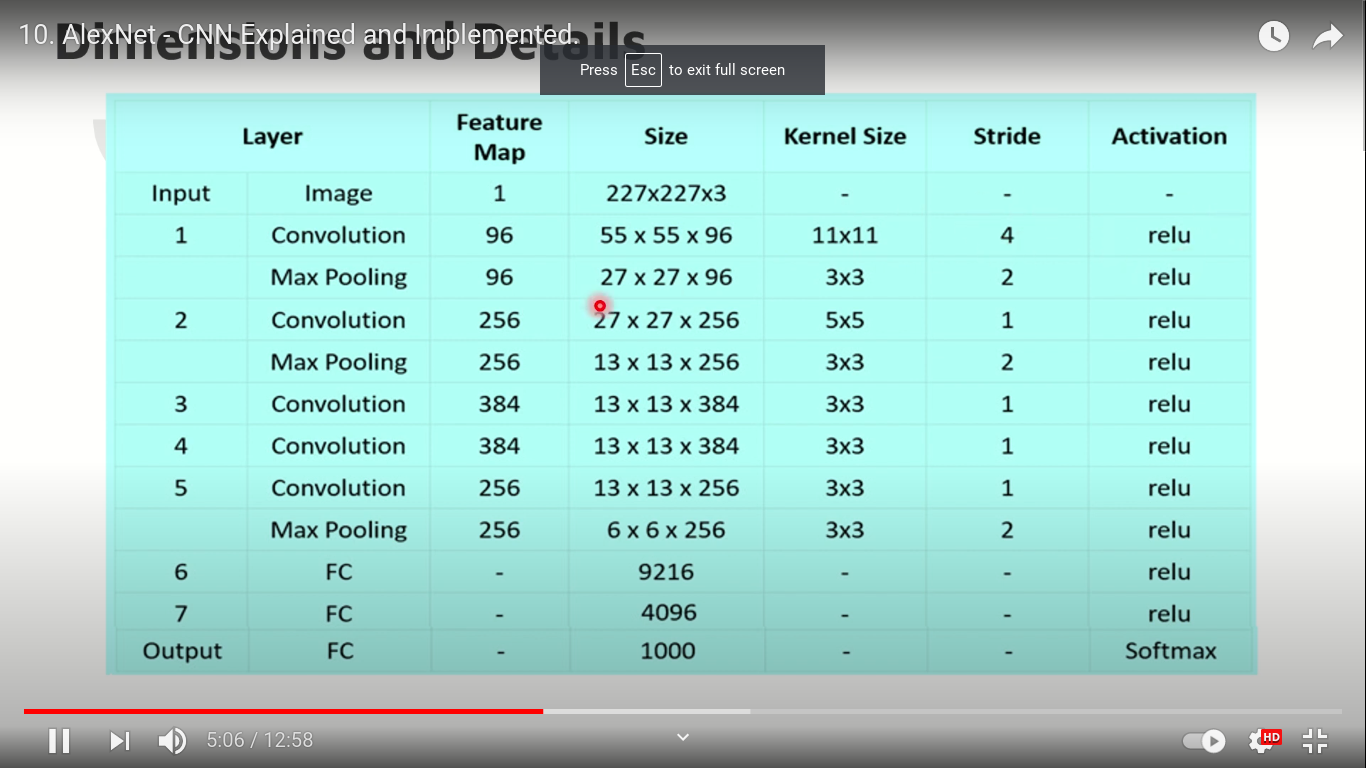

In [10]:
%tensorflow_version 2.x
import tensorflow as tf 
import keras 
from keras import Sequential
from keras.layers import Dense,Activation,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.layers.normalization import BatchNormalization
import random
import numpy as np
from tqdm import tqdm

assert len(tf.config.list_physical_devices('GPU')) > 0

#set up alexnet

def build_alexnet_model():
  image_shape = (80,60,1)
  np.random.seed(1000)
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=96,input_shape = image_shape, kernel_size=(11,11),strides=(4,4), padding='valid',activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'),
    tf.keras.layers.Conv2D(filters=256,kernel_size=(5,5),strides=(1,1), padding='valid',activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'),
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1), padding='valid',activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=384,kernel_size=(3,3),strides=(1,1), padding='valid',activation=tf.nn.relu), 
    tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1), padding='valid',activation=tf.nn.relu), 
    tf.keras.layers.MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(4096, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3, activation=tf.keras.activations.linear)])
  
  return model

model = build_alexnet_model()

a = np.zeros((80,60,1))

model.predict(a)

print(model.summary())


#model.build()

#model.summary()


#model.compile(loss=keras.losses.MeanSquaredError(),optimizer='adam',metrics=["accuracy"])
  #return model



#loss f'n: mse

ValueError: ignored

In [ ]:
#train + save weights ever once in a while